In [303]:
import os
import re
import h5py
import os
from tqdm import tqdm

from nltk import tokenize
from sklearn import preprocessing

from keras.preprocessing.text import Tokenizer, text_to_word_sequence
# from attention import Attention_input1, Attention_input2
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.layers import Reshape, Dense, Input, Flatten, Dropout, merge, BatchNormalization
from keras.layers import TimeDistributed, LSTM, GRU, Bidirectional
from keras.models import Model
# from keras.optimizers import SGD, Adadelta, Adam, RMSprop
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers.core import Reshape, RepeatVector

from keras.callbacks import EarlyStopping
from keras.models import Sequential, Model
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Input, Convolution1D, MaxPooling1D
import torch
import numpy as np
from transformers import BertTokenizer, BertForMaskedLM, BertModel
import tensorflow as tf
from keras.applications.vgg16 import VGG16
from tensorflow.keras import Model

from tensorflow.python.keras.layers import Layer, InputSpec
from keras import backend as K
from keras import initializers,regularizers,constraints
# from keras.optimizers import SGD, RMSprop, Adagrad

In [194]:
def read_text_file(path, multi_line=False):
    if multi_line == True:
        lines = open(path, 'r', encoding='latin-1').readlines()
        lines = [line.rstrip('\n') for line in lines]
        return lines
    return open(path, 'r', encoding='latin-1').read()

In [195]:
mvsa_single_texts = read_text_file('../input/mvsa-data/mvsa-single-data/mvsa-single-texts.txt', multi_line=True)
mvsa_single_images = np.load('../input/mvsa-data/mvsa-single-data/mvsa-single-images.npy')
mvsa_single_labels = read_text_file('../input/mvsa-data/mvsa-single-data/mvsa-single-labels.txt', multi_line=True)

neutral
Looking forward to #Disgraced by Ayad Akhtar! Monday and tuesday are already sold out! 


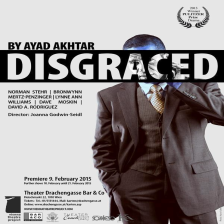

In [196]:
print(mvsa_single_labels[23])
print(mvsa_single_texts[23])
tf.keras.utils.array_to_img(mvsa_single_images[23])

# Visual Features

In [197]:
vgg16 = VGG16(input_shape=(224, 224, 3))
vgg16.trainable = False # Freeze pre-trained layers
model_vgg16 = Model(inputs=vgg16.input, outputs=vgg16.layers[-2].output)
vgg_features = model_vgg16.predict(mvsa_single_images[:10])

In [ ]:
a = model_vgg16.predict(mvsa_single_images[:2])

In [199]:
vgg_features = model_vgg16.predict(mvsa_single_images[:10])

# MultiSentiNet

In [224]:
class Attention_input2(Layer):
    def __init__(self,
                 W_regularizer=None, u_regularizer=None, b_regularizer=None,
                 W_constraint=None, u_constraint=None, b_constraint=None,
                 Wo_regularizer=None,
                 Wo_constraint=None,
                 Ws_regularizer=None,
                 Ws_constraint=None,
                 bias=True, **kwargs):

        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.Wo_regularizer = regularizers.get(Wo_regularizer)
        self.Ws_regularizer = regularizers.get(Ws_regularizer)

        self.u_regularizer = regularizers.get(u_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.Wo_constraint = constraints.get(Wo_constraint)
        self.Ws_constraint = constraints.get(Ws_constraint)

        self.u_constraint = constraints.get(u_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        super(Attention_input2, self).__init__(**kwargs)

    def build(self, input_shape):
        shape1 = input_shape[0]
        shape2 = input_shape[1]
        shape3 = input_shape[1]

        assert len(shape1) == 3

        self.W = self.add_weight(shape=(shape1[-1], shape1[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)


        self.Wo = self.add_weight(shape=(shape2[-1],shape2[-1], ),
                                 initializer=self.init,
                                 name='{}_Wo'.format(self.name),
                                 regularizer=self.Wo_regularizer,
                                 constraint=self.Wo_constraint)

        self.Ws = self.add_weight(shape=(shape3[-1],shape3[-1], ),
                                 initializer=self.init,
                                 name='{}_Ws'.format(self.name),
                                 regularizer=self.Ws_regularizer,
                                 constraint=self.Ws_constraint)

        if self.bias:
            self.b = self.add_weight(shape=(shape1[-1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)

        self.u = self.add_weight(shape=(shape1[-1],),
                                 initializer=self.init,
                                 name='{}_u'.format(self.name),
                                 regularizer=self.u_regularizer,
                                 constraint=self.u_constraint)

        super(Attention_input2, self).build(input_shape)

    def compute_mask(self, input, input_mask=None):
        # do not pass the mask to the next layers
        return None

    def call(self, input, mask=None):
        x = input[0]
        o = input[1]
        s = input[2]

        uit_x = K.dot(x, self.W)
        uit_o = K.dot(o, self.Wo)
        uit_s = K.dot(s, self.Ws)

        uit = uit_x + uit_o + uit_s

        if self.bias:
            uit += self.b

        uit = K.tanh(uit)
        ait = K.dot(uit, self.u)

        a = K.exp(ait)

        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())
        a = K.expand_dims(a)
        weighted_input = x * a
        return K.sum(weighted_input, axis=1)

    def get_output_shape_for(self, input_shape):
        shape1 = input_shape[0]
        return shape1[0], shape1[-1]

In [202]:
MAX_SEQUENCE_LENGTH = 140 # as in twitter post word limit
MAX_NB_WORDS = 10000
EMBEDDING_DIM = 200
VALIDATION_SPLIT = 0.1
NB_EPOCH = 100
NB_CLASS = 3
DIM_HIDDEN = 128
DIM_LSTM = 128

In [203]:
# e.g. validation_split=0.1 -----> 8:1:1 ratio of train, val, test
def split_data(data, validation_split):
    nb_validation_samples = int(validation_split * data.shape[0])
    data_train = data[:-(nb_validation_samples * 2)]
    data_val = data[-(nb_validation_samples * 2):-(nb_validation_samples)]
    data_test = data[-nb_validation_samples:]
    
    return data_train, data_val, data_test

In [204]:
def dp_txt(txt):
    # nonEnglish_regex = re.compile('[^a-zA-Z0-9\\?\\!\\,\\.@#\\+\\-=\\*\'\"><&\\$%\\(\\)\\[\\]:;]+')
    hashtag_pattern = re.compile('#[a-zA-Z0-9]+')
    at_pattern = re.compile('@[a-zA-Z0-9]+')
    http_pattern = re.compile("((http|ftp|https)://)(([a-zA-Z0-9\._-]+\.[a-zA-Z]{2,6})|([0-9]{1,3}\.[0-9]{1,3}\.[0-9]{1,3}\.[0-9]{1,3}))(:[0-9]{1,4})*(/[a-zA-Z0-9\&%_\./-~-]*)?")
    txt = txt.strip()
    txt_hashtag = re.sub(hashtag_pattern, '', txt)
    txt_nonat = re.sub(at_pattern, '', txt_hashtag)
    txt_nonhttp = re.sub(http_pattern, '', txt_nonat)
    txt = txt_nonhttp
    return txt

In [205]:
new_texts = []
for idx in range(len(mvsa_single_texts[:10])):
    text = mvsa_single_texts[idx]
    text = dp_txt(str(text))
    new_texts.append(text)
texts = new_texts

tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
word_index = tokenizer.word_index
text_data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')


In [209]:
le = preprocessing.LabelEncoder()
le.fit_transform(mvsa_single_labels)
labels = le.transform(mvsa_single_labels)
labels = to_categorical(np.asarray(labels))

In [216]:
text_train, text_val, text_test = split_data(text_data[:10], VALIDATION_SPLIT)
label_train,label_val, label_test = split_data(labels[:10], VALIDATION_SPLIT)
# image_train, image_val, image_test = split_data(mvsa_single_images, VALIDATION_SPLIT)
scene_train,scene_val,scene_test = split_data(vgg_features,VALIDATION_SPLIT)
object_train,object_val,object_test = split_data(vgg_features,VALIDATION_SPLIT)

text_shape = text_train.shape[1:]
scene_shape = scene_train.shape[1:]
object_shape = object_train.shape[1:]

In [214]:
embeddings_index = {}
f = open('../input/glovetwitter27b100d/glove.twitter.27B.100d.txt')
for line in f:
    values = line.split()
    word = values[2]
    coefs = np.asarray(values[1], dtype='float32')
    embeddings_index[word] = coefs
f.close()

nb_words = min(MAX_NB_WORDS, len(word_index))
embedding_matrix = np.zeros((nb_words + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    if i > MAX_NB_WORDS:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

embedding_layer = Embedding(nb_words + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=True)

In [215]:
checkpoint = ModelCheckpoint('./model_checkpoint/{}.hdf5'.format('MultiSentiNet'), save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=5)

In [219]:
# Image Sence
scene_input = Input(shape=scene_shape, dtype='float32')
img_scene = Dense(DIM_HIDDEN, activation='relu')(scene_input)
img_scene_encoder = RepeatVector(text_shape[0], name='scene-repeat')(img_scene)

# Image Object
object_input = Input(shape=object_shape, dtype='float32')
img_object = Dense(DIM_HIDDEN, activation='relu')(object_input)
img_object_encoder = RepeatVector(text_shape[0], name='object-repeat')(img_object)

In [ ]:
# Text
txt_input = Input(shape=text_shape, dtype='float32')
txt = embedding_layer(txt_input)
txt_hidden = (LSTM(DIM_HIDDEN, return_sequences=True, name='tweet-lstm'))(txt)
txt_att = Attention_input2(name='att_so')([txt_hidden, img_object_encoder, img_scene_encoder])

In [ ]:
def average_LSTM_sentence(word_embedddings):
    embedding_sum = [np.zeros(word_embedddings.shape[1:])]
    
    for i in word_embedddings:
        embedding_sum += i
        
    return embedding_sum / word_embeddings.shape[1]

In [ ]:
# Merge
# img_txt = merge([img_scene, img_object, txt_att], mode='concat')
img_txt = merge([image_hidden, txt_hidden, txt_hidden], mode='concat')
img_txt = Dense(DIM_HIDDEN, activation='relu')(img_txt)
img_txt_loss = Dense(NB_CLASS, activation='softmax', name='main_output') (img_txt)

# BERT

In [ ]:
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')# bert_model = BertForMaskedLM.from_pretrained('bert-base-uncased', return_dict = True)
bert_model = BertModel.from_pretrained('bert-base-uncased', output_hidden_states=True)
bert_model.eval() # put model in evaluation model. turn of regularization in training
print()

In [ ]:
le = preprocessing.LabelEncoder()
le.fit_transform(mvsa_single_labels)
tokenized_labels = le.transform(mvsa_single_labels)

In [ ]:
text = mvsa_single_texts[0]
text_data = pad_sequences(text, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')
labels = to_categorical(np.asarray(tokenized_labels))

In [282]:
# text = mvsa_single_texts[0]
# inputs = bert_tokenizer(text, return_tensors="pt")
# outputs = bert_model(**inputs)
# last_hidden_states = outputs.last_hidden_state
# bert_embeddings = torch.squeeze(last_hidden_states, dim=0)

In [305]:
# get all token embeddings with padding
def bert_embed(tokens_tensor, segments_tensor):
    
#     marked_text = "[CLS] " + text + " [SEP]"
#     tokenized_text = bert_tokenizer.tokenize(marked_text) # Tokenize our sentence with the BERT tokenizer.
#     indexed_tokens = bert_tokenizer.convert_tokens_to_ids(tokenized_text) # Map the token strings to their vocabulary indeces.

#     padded = pad_sequences([indexed_tokens], maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')[0]

#     segments_ids = [1] * MAX_SEQUENCE_LENGTH
#     tokens_tensor = torch.tensor([padded])
#     segments_tensors = torch.tensor([segments_ids])

    with torch.no_grad():
        outputs = bert_model(tokens_tensor, segments_tensors)

        # Evaluating the model will return a different number of objects based on 
        # how it's  configured in the `from_pretrained` call earlier. In this case, 
        # becase we set `output_hidden_states = True`, the third item will be the 
        # hidden states from all layers. See the documentation for more details:
        # https://huggingface.co/transformers/model_doc/bert.html#bertmodel
        
        hidden_states = outputs[2]
        last_hidden_states = hidden_states[-1]
        bert_embeddings = torch.squeeze(last_hidden_states, dim=0).numpy()
    return bert_embeddings

# text = mvsa_single_texts[0]
# bert_embed(text).shape

In [307]:
def phobert_embed_data(data, tokenizer=bert_tokenizer):
    # embed the whole dataset with phobert
    # param padded_data: tokenized, padded dataset
    # param mask_data: attention masks of the padded dataset
    MAX_LENGTH = MAX_SEQUENCE_LENGTH

    embedded_data = np.array([])
    for text in tqdm(data):
        
        marked_text = "[CLS] " + text + " [SEP]"
        tokenized_text = tokenizer.tokenize(marked_text) # Tokenize our sentence with the BERT tokenizer.
        indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text) # Map the token strings to their vocabulary indeces.
        padded = pad_sequences([indexed_tokens], maxlen=MAX_LENGTH, padding='post', truncating='post')[0]
        segments_ids = [1] * MAX_LENGTH
        tokens_tensor = torch.tensor([padded])
        segments_tensors = torch.tensor([segments_ids])

        bert_embeddings = bert_embed(tokens_tensor, segments_tensors)
        
        if embedded_data.shape[0] == 0:
            embedded_data = np.array([bert_embeddings])#np.empty((0, embedded_line.shape[0]), 'float32')
        else:
            embedded_data = np.concatenate((embedded_data, [bert_embeddings]))

#         embedded_data = np.concatenate((embedded_data, [embedded_line]))
    return embedded_data

In [310]:
bert_features = phobert_embed_data(mvsa_single_texts[:10])

100%|██████████| 10/10 [00:02<00:00,  3.59it/s]


In [ ]:
vgg16 = VGG16(input_shape=(224, 224, 3))
vgg16.trainable = False # Freeze pre-trained layers
model_vgg16 = Model(inputs=vgg16.input, outputs=vgg16.layers[-2].output)
vgg_features = model_vgg16.predict(mvsa_single_images[:10])

In [313]:
# SFNN Semantic feature fusion neural network for mutimodal sentiment analysis

image_input = Input(shape=vgg_features.shape[1:])
text_input = Input(shape=bert_features.shape[1:])



# output = vgg16.layers[-2].build #vgg16.layers[-2]
# mod = Model(image_input, output)

In [277]:
vgg_features.shape[1:]

(4096,)

# Drafts

In [ ]:
# EMB_DIM = 100
# MAX_WORDS = 1000
# if max_words is not None: 
#     VOCAB_LEN = max_words 
# else:
#     VOCAB_LEN = len(word_index)+1
# embedding_matrix = np.zeros((VOCAB_LEN, EMB_DIM))
# oov_count = 0
# oov_words = []
# for word, idx in word_index.items():
#     if idx < VOCAB_LEN:
#         embedding_vector = embedding_vectors.get(word)
#         if embedding_vector is not None:
#             embedding_matrix[idx] = embedding_vector

In [ ]:
# padded = pad_sequences([inputs['input_ids'][0]], maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')[0]
# inputs['input_ids'] = torch.tensor(padded).to(torch.long)
# mask = np.where(padded == 0, 0, 1)
# inputs['attention_mask'] = torch.tensor(mask)
# token_type_ids = [0] * len(padded)
# inputs['token_type_ids'] = torch.tensor(token_type_ids)

In [ ]:
# encoding = bert_tokenizer.encode_plus(mvsa_single_texts[0], add_special_tokens=True, truncation=True, padding='max_length', return_attention_mask=True, return_tensors="pt")
# tokenized_text = encoding['input_ids'][0]
# attention_mask = encoding["attention_mask"][0]